# Fully Connected Neural Network for Classification

## Import

In [1]:
import torch
from torch.utils.data import  TensorDataset , DataLoader
import torch.nn as nn
from torchmetrics import R2Score , Accuracy
import torch.optim as optim


import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Load and Prepare Data

In [2]:
df_train = pd.read_csv("Data/train.csv")
df_test = pd.read_csv("Data/test_with_price_range.csv")

x = df_train.drop('price_range' , axis=1)
y = df_train['price_range']

x_train , x_valid , y_train , y_valid = train_test_split(x , y , train_size=0.75 , random_state=8)
x_train.shape , x_valid.shape , y_train.shape , y_valid.shape

((1500, 20), (500, 20), (1500,), (500,))

In [3]:
x_train = torch.FloatTensor(x_train.values)
y_train = torch.LongTensor(y_train.values).squeeze()

x_valid = torch.FloatTensor(x_valid.values)
y_valid = torch.LongTensor(y_valid.values).squeeze()

In [4]:
Mean = x_train.mean(dim=0)
Std = x_train.std(dim=0)

x_train = (x_train - Mean) / Std
x_valid = (x_valid - Mean) / Std

In [5]:
train_data = TensorDataset(x_train , y_train)
train_dataloader = DataLoader(train_data , 200 , shuffle=True)


In [6]:
valid_dataset = TensorDataset(x_valid, y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=100, shuffle=False)


## Model

In [7]:
num_feats = 20
num_class = 4
h1 = 64
h2 = 32

model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02)


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

##  Train The Model

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
num_epochs = 500

loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

for epoch in range(num_epochs):
  loss_train = AverageMeter()
  acc_train = Accuracy(task="multiclass", num_classes=4).to(device)
  for i, (inputs, targets) in enumerate(train_dataloader):
    inputs = inputs.to(device)
    targets = targets.to(device)

    outputs = model(inputs)
    
    loss = loss_fn(outputs, targets)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_train.update(loss.item())
    acc_train(outputs, targets)

  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task="multiclass", num_classes=4).to(device)
    for i, (inputs, targets) in enumerate(valid_dataloader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      
      loss_valid.update(loss.item())
      acc_valid(outputs, targets)

  loss_train_hist.append(loss_train.avg)
  loss_valid_hist.append(loss_valid.avg)

  acc_train_hist.append(float(acc_train.compute()))
  acc_valid_hist.append(float(acc_valid.compute()))

  if epoch % 10 == 0:
    print(f'Epoch {epoch}')
    print(f'Train: Loss = {loss_train.avg:.4}, Acc = {float(acc_train.compute()):.4}')
    print(f'Valid: Loss = {loss_valid.avg:.4}, Acc = {float(acc_valid.compute()):.4}')
    print()

Epoch 0
Train: Loss = 1.38, Acc = 0.264
Valid: Loss = 1.378, Acc = 0.28

Epoch 10
Train: Loss = 1.342, Acc = 0.44
Valid: Loss = 1.34, Acc = 0.422

Epoch 20
Train: Loss = 1.271, Acc = 0.5267
Valid: Loss = 1.267, Acc = 0.526

Epoch 30
Train: Loss = 1.129, Acc = 0.5693
Valid: Loss = 1.124, Acc = 0.582

Epoch 40
Train: Loss = 0.9421, Acc = 0.61
Valid: Loss = 0.9371, Acc = 0.624

Epoch 50
Train: Loss = 0.7794, Acc = 0.7207
Valid: Loss = 0.7775, Acc = 0.72

Epoch 60
Train: Loss = 0.6531, Acc = 0.83
Valid: Loss = 0.6564, Acc = 0.822

Epoch 70
Train: Loss = 0.5588, Acc = 0.872
Valid: Loss = 0.5632, Acc = 0.858

Epoch 80
Train: Loss = 0.4789, Acc = 0.8973
Valid: Loss = 0.4903, Acc = 0.882

Epoch 90
Train: Loss = 0.4162, Acc = 0.9127
Valid: Loss = 0.4331, Acc = 0.892

Epoch 100
Train: Loss = 0.3685, Acc = 0.924
Valid: Loss = 0.3868, Acc = 0.904

Epoch 110
Train: Loss = 0.3242, Acc = 0.9347
Valid: Loss = 0.35, Acc = 0.91

Epoch 120
Train: Loss = 0.2948, Acc = 0.948
Valid: Loss = 0.32, Acc = 0.916

## Visualize Loss And Accuracy

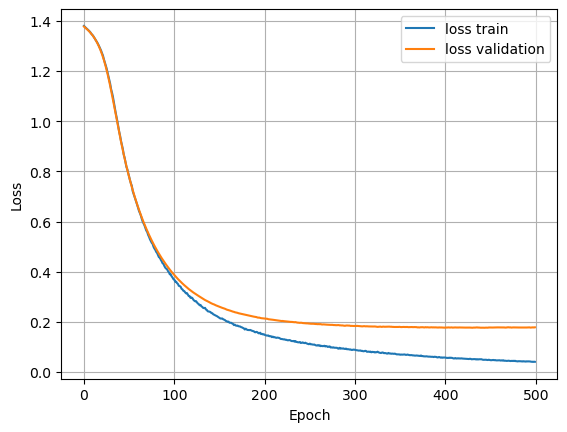

In [12]:
plt.plot(loss_train_hist , label = 'loss train' )
plt.plot(loss_valid_hist, label = 'loss validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

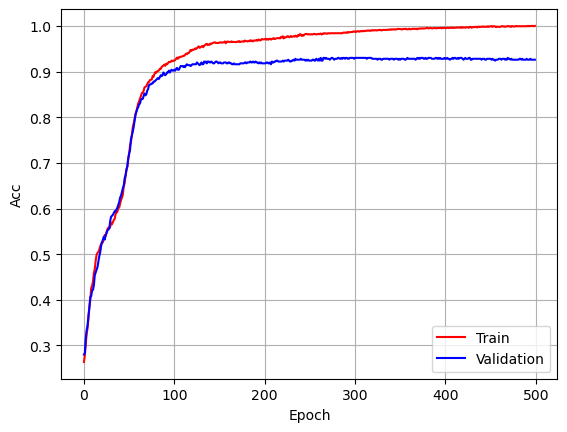

In [13]:
plt.plot(range(num_epochs), acc_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

## Save Model

In [14]:
torch.save(model, 'phone_price_range.pth')

## Loading And Testing Model  

In [15]:
mymodel = torch.load('phone_price_range.pth')


C:\Users\BEHRAD\AppData\Local\Temp\ipykernel_25268\2472039404.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mymodel = torch.load('phone_price_range.pth')


In [16]:
df_test = df_test.drop("id" , axis=1)
df_test.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1043,1,1.8,1,14,0,5,0.1,193,3,...,226,1412,3476,12,7,2,0,1,0,3
1,841,1,0.5,1,4,1,61,0.8,191,5,...,746,857,3895,6,0,7,1,0,0,3
2,1807,1,2.8,0,1,0,27,0.9,186,3,...,1270,1366,2396,17,10,10,0,1,1,3
3,1546,0,0.5,1,18,1,25,0.5,96,8,...,295,1752,3893,10,0,7,1,1,0,3
4,1434,0,1.4,0,11,1,49,0.5,108,6,...,749,810,1773,15,8,7,1,0,1,1


In [17]:
x = df_test.drop('price_range' , axis=1)
y = df_test['price_range']

In [18]:
x_test = torch.FloatTensor(x.values)
x_test  = (x_test - Mean) / Std
x_test = x_test.to(device)
y_test = torch.LongTensor(y.values).squeeze().to(device)

In [19]:
y_hat_test = mymodel(x_test)
acc_test = Accuracy(task="multiclass", num_classes=4).to(device)
test_accuracy = acc_test(y_hat_test, y_test)
print(f'Test Accuracy: {test_accuracy:.4}')

Test Accuracy: 0.872
